# Deep Learning Final Project

Data downloaded from Kaggle.com: https://www.kaggle.com/datasets/johnbergmann/captcha-image-dataset

In [2]:
import os
import glob

import numpy as np
import pandas as pd
import seaborn as sns
from PIL import Image

import warnings
warnings.simplefilter('ignore')

import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from sklearn.preprocessing import OneHotEncoder

2024-01-05 19:49:45.440242: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Download captcha dataset

In [3]:
# !kaggle datasets download -d johnbergmann/captcha-image-dataset

In [4]:
# !unzip captcha-image-dataset.zip

In [5]:
!ls captchas/test/*.jpeg | wc -l

1500


Convert the jpegs to a dataframe and take the label from the filename for the labels

In [6]:
# Define path to training set
path = "./captchas/train/"

# get a list of the file names
filenames = glob.glob("*.jpeg", root_dir=path)

# Number of samples and the number of features
n_train = len(filenames)
with Image.open(path+filenames[0]) as im:
    w, h = im.size

# Transform it into raw data
X_train = np.zeros((n_train, h, w, 1))
labels_train = np.zeros(n_train, dtype=object)
for filename in filenames:
    # Get the label from the filename
    idx, label = filename[:-5].split("_")
    idx = int(idx)
    labels_train[idx] = label.upper()
    
    # Get the pixel data from the image
    with Image.open(path+filename) as im:
        # Convert to grayscale
        im = im.convert('L')
        X_train[idx] = np.array(im).reshape(h,w,1)
        
X_train /= 255
X_train.shape

(8501, 50, 250, 1)

Let's look at one of the captchas

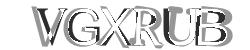

In [7]:
def show_im(pixels):
    if pixels.shape[-1] == 1:
        pixels = pixels.reshape(pixels.shape[:-1])
    im = Image.fromarray(np.uint8(pixels*255))
    im.show()
    
show_im(X_train[0])

Transform the labels into each character and separate by character position

In [8]:
labels_train = np.array([list(label) for label in labels_train], dtype=object)

y_train = {}
encoders = {}
for i in range(labels_train.shape[1]):
    encoder = OneHotEncoder(sparse_output=False)
    y_train[i] = encoder.fit_transform(labels_train[:,i].reshape(-1,1))
    encoders[i] = encoder
    
print(y_train[0])
print(encoders[0])

[[0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
OneHotEncoder(sparse_output=False)


Do the same for `X_test` and `y_test`

In [9]:
# Define path to training set
path = "./captchas/test/"

# get a list of the file names
filenames = glob.glob("*.jpeg", root_dir=path)

# Number of samples and the number of features
n_test = len(filenames)
with Image.open(path+filenames[0]) as im:
    w, h = im.size

# Transform it into raw data
X_test = np.zeros((n_test, h, w, 1))
labels_test = np.zeros(n_test, dtype=object)
for filename in filenames:
    # Get the label from the filename
    idx, label = filename[:-5].split("_")
    idx = int(idx) - n_train 
    labels_test[idx] = label.upper()
    
    # Get the pixel data from the image
    with Image.open(path+filename) as im:
        # Convert to grayscale
        im = im.convert('L')
        X_test[idx] = np.array(im).reshape(h,w,1)
        
X_test /= 255
X_test.shape

(1500, 50, 250, 1)

In [10]:
labels_test = np.array([list(label) for label in labels_test], dtype=object)

y_test = {}
for i in range(labels_test.shape[1]):
    y_test[i] = encoders[i].transform(labels_test[:,i].reshape(-1,1))
    
y_test[0]

array([[0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

Build a basic model for identifying the first character

In [10]:
keras.backend.clear_session()
n_classes = y_train[0].shape[1]

# Simple CNN
model_1 = Sequential()

# Convolutional layer with 32 filters and size 5x5 and stride 2
model_1.add(Conv2D(32, 5, strides=2, padding='same', 
                   activation='relu', input_shape=X_train.shape[1:]))

# MaxPooling layer with size 2
model_1.add(MaxPooling2D(pool_size=2))

# Flatten the data and feed into dense layers
model_1.add(Flatten())
model_1.add(Dense(64, activation='relu'))
model_1.add(Dense(n_classes, activation='softmax'))

model_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 25, 125, 32)       832       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 12, 62, 32)       0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 23808)             0         
                                                                 
 dense (Dense)               (None, 64)                1523776   
                                                                 
 dense_1 (Dense)             (None, 21)                1365      
                                                                 
Total params: 1,525,973
Trainable params: 1,525,973
Non-trainable params: 0
______________________________________________

2024-01-05 16:50:14.349595: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [11]:
model_1.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [12]:
char_pos = 0
model_1.fit(X_train, y_train[char_pos],
              batch_size=64,
              epochs=15,
              validation_data=(X_test, y_test[char_pos]),
              shuffle=True)

Epoch 1/15
133/133 [==============================] - 15s 109ms/step - loss: 3.0686 - accuracy: 0.0621 - val_loss: 3.0015 - val_accuracy: 0.0967
Epoch 2/15
133/133 [==============================] - 13s 101ms/step - loss: 2.6952 - accuracy: 0.2073 - val_loss: 2.3593 - val_accuracy: 0.2753
Epoch 3/15
133/133 [==============================] - 16s 119ms/step - loss: 1.7665 - accuracy: 0.4707 - val_loss: 1.7355 - val_accuracy: 0.4700
Epoch 4/15
133/133 [==============================] - 15s 113ms/step - loss: 1.1850 - accuracy: 0.6499 - val_loss: 1.4292 - val_accuracy: 0.5827
Epoch 5/15
133/133 [==============================] - 15s 115ms/step - loss: 0.8391 - accuracy: 0.7626 - val_loss: 1.2897 - val_accuracy: 0.6020
Epoch 6/15
133/133 [==============================] - 16s 118ms/step - loss: 0.6022 - accuracy: 0.8451 - val_loss: 1.1077 - val_accuracy: 0.6653
Epoch 7/15
133/133 [==============================] - 16s 121ms/step - loss: 0.4405 - accuracy: 0.8914 - val_loss: 1.0251 - val_ac

In [13]:
y_pred = model_1.predict(X_test)

47/47 [==============================] - 1s 13ms/step


In [14]:
y_pred.shape

(1500, 21)

In [12]:
# Translate into 0s and 1s so it can be back transformed by encoder
def pred_classes(y_pred):
    classes = np.argmax(y_pred, axis=1)
    y_pred = np.zeros_like(y_pred)
    
    for i in range(len(y_pred)):
        y_pred[i, classes[i]] = 1
    
    return y_pred

# y_pred = pred_classes(y_pred)

In [16]:
encoders[0].inverse_transform(y_pred).flatten()

array(['N', 'P', 'N', ..., 'S', 'B', 'R'], dtype=object)

In [17]:
encoders[0].inverse_transform(y_test[0]).flatten()

array(['A', 'P', 'N', ..., 'G', 'H', 'R'], dtype=object)

In [18]:
# Train all models

def train_model(X_train, X_test, y_train, y_test):
    # Clear the current model
    keras.backend.clear_session()
    
    n_classes = y_train.shape[1]

    # Simple CNN
    model = Sequential()

    # Convolutional layer with 32 filters and size 5x5 and stride 2
    model.add(Conv2D(32, 5, strides=2, padding='same', activation='relu',
                     input_shape=X_train.shape[1:]))
    
    # Convolutional layer with 32 filters and size 5x5 and stride 2
    model.add(Conv2D(32, 5, strides=2, padding='same', activation='relu'))
    
    # MaxPooling layer with size 2
    model.add(MaxPooling2D(pool_size=2))
    model.add(Dropout(0.25))

    # Flatten the data and feed into dense layers
    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(Dense(n_classes, activation='softmax'))
    
    model.summary()
    
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    model.fit(X_train, y_train,
                  batch_size=64,
                  epochs=15,
                  validation_data=(X_test, y_test),
                  shuffle=True)

    return model

In [19]:
models1 = {}
for i in range(6):
    models1[i] = train_model(X_train, X_test, y_train[i], y_test[i])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 25, 125, 32)       832       
                                                                 
 conv2d_1 (Conv2D)           (None, 13, 63, 32)        25632     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 6, 31, 32)        0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 6, 31, 32)         0         
                                                                 
 flatten (Flatten)           (None, 5952)              0         
                                                                 
 dense (Dense)               (None, 64)                380992    
                                                        

                                                                 
 dense_1 (Dense)             (None, 21)                1365      
                                                                 
Total params: 408,821
Trainable params: 408,821
Non-trainable params: 0
_________________________________________________________________
Epoch 1/15
133/133 [==============================] - 20s 150ms/step - loss: 3.0469 - accuracy: 0.0507 - val_loss: 3.0426 - val_accuracy: 0.0533
Epoch 2/15
133/133 [==============================] - 18s 133ms/step - loss: 2.8194 - accuracy: 0.1403 - val_loss: 2.4185 - val_accuracy: 0.2560
Epoch 3/15
133/133 [==============================] - 18s 138ms/step - loss: 1.9895 - accuracy: 0.3868 - val_loss: 1.7531 - val_accuracy: 0.4493
Epoch 4/15
133/133 [==============================] - 17s 131ms/step - loss: 1.3629 - accuracy: 0.5805 - val_loss: 1.3434 - val_accuracy: 0.5887
Epoch 5/15
133/133 [==============================] - 18s 139ms/step - loss: 1.0072 

133/133 [==============================] - 19s 141ms/step - loss: 0.9549 - accuracy: 0.6954 - val_loss: 1.1263 - val_accuracy: 0.6553
Epoch 6/15
133/133 [==============================] - 21s 157ms/step - loss: 0.7746 - accuracy: 0.7524 - val_loss: 1.0685 - val_accuracy: 0.6920
Epoch 7/15
133/133 [==============================] - 20s 148ms/step - loss: 0.6107 - accuracy: 0.8043 - val_loss: 1.0257 - val_accuracy: 0.6973
Epoch 8/15
133/133 [==============================] - 20s 151ms/step - loss: 0.5244 - accuracy: 0.8320 - val_loss: 0.9874 - val_accuracy: 0.7147
Epoch 9/15
133/133 [==============================] - 19s 143ms/step - loss: 0.4399 - accuracy: 0.8593 - val_loss: 0.9804 - val_accuracy: 0.7127
Epoch 10/15
133/133 [==============================] - 20s 152ms/step - loss: 0.3822 - accuracy: 0.8747 - val_loss: 0.9899 - val_accuracy: 0.7167
Epoch 11/15
133/133 [==============================] - 20s 151ms/step - loss: 0.3347 - accuracy: 0.8904 - val_loss: 0.9819 - val_accuracy: 0

In [21]:
results1 = np.zeros((n_test,6), dtype=object)
for i in range(6):
    y_pred = pred_classes(models1[i].predict(X_test))
    results1[:,i] = encoders[i].inverse_transform(y_pred).flatten()

47/47 [==============================] - 0s 7ms/step


In [22]:
results1

array([['A', 'E', '6', 'X', 'A', 'H'],
       ['T', 'B', 'B', 'G', 'G', 'Z'],
       ['N', 'S', 'R', 'R', 'R', 'F'],
       ...,
       ['G', 'H', 'G', 'P', 'U', 'A'],
       ['H', '6', 'D', 'X', 'A', 'G'],
       ['R', 'U', 'B', 'R', 'M', 'P']], dtype=object)

In [23]:
labels_test == results1

array([[ True,  True,  True,  True,  True,  True],
       [False,  True,  True,  True, False,  True],
       [ True,  True,  True, False,  True,  True],
       ...,
       [ True,  True,  True,  True, False,  True],
       [ True, False,  True,  True,  True,  True],
       [ True, False,  True,  True,  True,  True]])

In [24]:
np.sum(results1 == labels_test)

7221

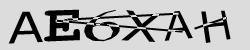

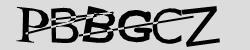

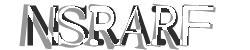

In [25]:
for i in range(3):
    show_im(X_test[i])

In [26]:
idx = results1[:,0] != labels_test[:,0]
pd.DataFrame([results1[idx, 0], labels_test[idx, 0]], index=['Predicted', 'True']).T

,Predicted,True
0,T,P
1,E,F
2,R,B
3,H,B
4,K,X
...,...,...
229,B,P
230,G,C
231,S,6
232,V,N


<Axes: >

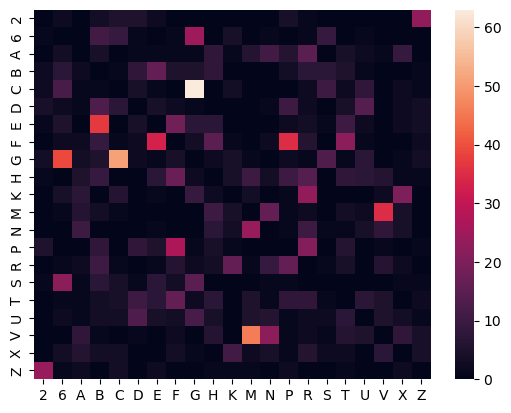

In [56]:
l = np.unique(labels_test)
n_labels = len(l)
mismatches = pd.DataFrame(np.zeros((n_labels, n_labels)), index=l, columns=l, dtype=int)
for i in range(results1.shape[0]):
    for j in range(6):
        if results1[i,j] == labels_test[i,j]:
            continue
        mismatches.loc[labels_test[i,j], results1[i,j]] += 1

sns.heatmap(mismatches)

In [13]:
def label_accuracy(y_true, y_pred):
    bool_array = y_true == y_pred
    total = np.sum(bool_array) / y_true.size
    per_label = [np.all(y_true[i] == y_pred[i]) for i in range(len(y_true))]
    per_label = np.sum(per_label) / len(y_true)
    print(f"Per Character Accuracy: {total:.2%}")
    print(f"Per Label Accuracy: {per_label:.2%}")

In [28]:
label_accuracy(labels_test, results1)

Per Character Accuracy: 80.23%
Per Label Accuracy: 39.60%


### Transfer Learning

In [ ]:
keras.backend.clear_session()
char = 0
filters = 32
shape = 5
stride = 2
pad ='same'
act = 'relu'
n_classes = y_train[char].shape[1]

# Layers to be frozen
feature_layers = [
    Conv2D(filters, shape, strides=stride, padding=pad, activation=act,
           input_shape=X_train.shape[1:]),
    Conv2D(filters, shape, strides=stride, padding=pad, activation=act),
    MaxPooling2D(pool_size=2),
    Dropout(0.25),
    Flatten()
]

# Classification layers
class_layers = [
    Dense(512, activation=act),
    Dense(n_classes, activation='softmax')
]


# Simple CNN
model = Sequential(feature_layers + class_layers)
model.summary()

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(X_train, y_train[char],
              batch_size=64,
              epochs=15,
              validation_data=(X_test, y_test[char]),
              shuffle=True)

In [ ]:
# Freeze the feature layers and train for character 2
char = 1
for l in feature_layers:
    l.trainable = False
model.summary()

In [58]:
# Train all models
def train_model(X_train, X_test, y_train, y_test):
    # Clear the current model
    keras.backend.clear_session()
    
    # Store test results
    results = np.zeros((y_test[0].shape[0], 6), dtype=object)
    
    # Hyperparameters
    filters = 32
    shape = 5
    stride = 2
    pad ='same'
    act = 'relu'    
    n_classes = y_train[0].shape[1]
    
    # Layers to be frozen
    feature_layers = [
        Conv2D(filters, shape, strides=stride, padding=pad, activation=act,
               input_shape=X_train.shape[1:]),
        Conv2D(filters, shape, strides=stride, padding=pad, activation=act),
        Conv2D(filters, shape, strides=stride, padding=pad, activation=act),
        MaxPooling2D(pool_size=2),
        Dropout(0.25),
        Flatten()
    ]
    
    # Classification layers
    class_layers = [
        Dense(512, activation=act),
        Dropout(0.25),
        Dense(256, activation=act),
        Dense(n_classes, activation='softmax')
    ]

    # Simple CNN
    model = Sequential(feature_layers + class_layers)
    model.summary()
    
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    print("Character 1")
    model.fit(X_train, y_train[0],
                  batch_size=64,
                  epochs=15,
                  validation_data=(X_test, y_test[0]),
                  shuffle=True)
    
    # Save the prediction results
    y_pred = pred_classes(model.predict(X_test))
    results[:,0] = encoder.inverse_transform(y_pred).flatten()
    print()
    
    # Freeze the feature layers
    for l in feature_layers:
        l.trainable = False
        
    # Train the rest of the models using the frozen layers
    for i in range(1,6):
        print(f"Character {i+1}")
        model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
        model.fit(X_train, y_train[i],
                  batch_size=64,
                  epochs=15,
                  validation_data=(X_test, y_test[i]),
                  shuffle=True)
        y_pred = pred_classes(model.predict(X_test))
        results[:,i] = encoder.inverse_transform(y_pred).flatten()
        print()

    return results

In [59]:
results2 = train_model(X_train, X_test, y_train, y_test)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 25, 125, 32)       832       
                                                                 
 conv2d_1 (Conv2D)           (None, 13, 63, 32)        25632     
                                                                 
 conv2d_2 (Conv2D)           (None, 7, 32, 32)         25632     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 3, 16, 32)        0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 3, 16, 32)         0         
                                                                 
 flatten (Flatten)           (None, 1536)              0         
                                                        

133/133 [==============================] - 4s 30ms/step - loss: 0.3407 - accuracy: 0.8827 - val_loss: 0.7314 - val_accuracy: 0.7867
Epoch 15/15
47/47 [==============================] - 1s 14ms/step

Character 4
Epoch 1/15
133/133 [==============================] - 5s 36ms/step - loss: 4.1627 - accuracy: 0.0629 - val_loss: 2.9832 - val_accuracy: 0.0807
Epoch 2/15
133/133 [==============================] - 4s 31ms/step - loss: 2.8199 - accuracy: 0.1334 - val_loss: 2.5036 - val_accuracy: 0.2153
Epoch 3/15
133/133 [==============================] - 4s 30ms/step - loss: 2.3334 - accuracy: 0.2521 - val_loss: 2.0045 - val_accuracy: 0.3620
Epoch 4/15
133/133 [==============================] - 4s 30ms/step - loss: 1.9226 - accuracy: 0.3758 - val_loss: 1.6645 - val_accuracy: 0.4580
Epoch 5/15
133/133 [==============================] - 4s 31ms/step - loss: 1.5850 - accuracy: 0.4904 - val_loss: 1.4088 - val_accuracy: 0.5567
Epoch 6/15
133/133 [==============================] - 4s 31ms/step - loss:

In [60]:
label_accuracy(labels_test, results2)

Per Character Accuracy: 82.02%
Per Label Accuracy: 41.00%


<Axes: >

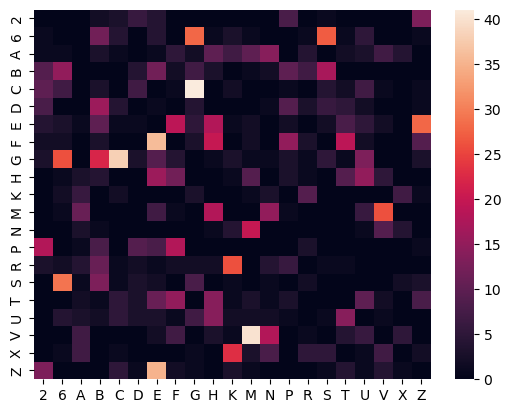

In [62]:
l = np.unique(labels_test)
n_labels = len(l)
mismatches = pd.DataFrame(np.zeros((n_labels, n_labels)), index=l, columns=l, dtype=int)
for i in range(results1.shape[0]):
    for j in range(6):
        if results2[i,j] == labels_test[i,j]:
            continue
        mismatches.loc[labels_test[i,j], results2[i,j]] += 1

sns.heatmap(mismatches)

### Fine Tuning

In [12]:
# Train all models
def train_model(X_train, X_test, y_train, y_test):
    # Clear the current model
    keras.backend.clear_session()
    
    # Store test results
    results = np.zeros((y_test[0].shape[0], 6), dtype=object)
    
    # Hyperparameters
    filters = 32
    shape = 5
    stride = 2
    pad ='same'
    act = 'relu'    
    n_classes = y_train[0].shape[1]
    
    # Layers to be frozen
    feature_layers = [
        Conv2D(filters, shape, strides=stride, padding=pad, activation=act,
               input_shape=X_train.shape[1:]),
        Conv2D(filters, shape, strides=stride, padding=pad, activation=act),
        Conv2D(filters, shape, strides=stride, padding=pad, activation=act),
        MaxPooling2D(pool_size=2),
        Dropout(0.25),
        Flatten()
    ]
    
    # Classification layers
    class_layers = [
        Dense(512, activation=act),
        Dropout(0.25),
        Dense(n_classes, activation='softmax')
    ]

    # Simple CNN
    model = Sequential(feature_layers + class_layers)
    model.summary()
    
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    print("Character 1")
    model.fit(X_train, y_train[0],
                  batch_size=64,
                  epochs=15,
                  validation_data=(X_test, y_test[0]),
                  shuffle=True)
    
    # Save the prediction results
    y_pred = pred_classes(model.predict(X_test))
    results[:,0] = encoder.inverse_transform(y_pred).flatten()
    print()
    
    # Freeze the feature layers
    for l in feature_layers:
        l.trainable = False
        
    # Train the rest of the models using the frozen layers
    for i in range(1,6):
        print(f"Character {i+1}")
        model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
        model.fit(X_train, y_train[i],
                  batch_size=64,
                  epochs=10,
                  validation_data=(X_test, y_test[i]),
                  shuffle=True)
        
        # Fine tuning
        for l in feature_layers:
            l.trainable = True
        learn_rate = 1e-5
        model.compile(loss='categorical_crossentropy', 
                      optimizer=keras.optimizers.Adam(learn_rate),
                      metrics=['accuracy'])
        model.fit(X_train, y_train[i],
                  batch_size=64,
                  epochs=5,
                  validation_data=(X_test, y_test[i]),
                  shuffle=True)
        
        for l in feature_layers:
            l.trainable = False
        
        y_pred = pred_classes(model.predict(X_test))
        results[:,i] = encoder.inverse_transform(y_pred).flatten()
        print()

    return results

results3 = train_model(X_train, X_test, y_train, y_test)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 25, 125, 32)       832       
                                                                 
 conv2d_1 (Conv2D)           (None, 13, 63, 32)        25632     
                                                                 
 conv2d_2 (Conv2D)           (None, 7, 32, 32)         25632     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 3, 16, 32)        0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 3, 16, 32)         0         
                                                                 
 flatten (Flatten)           (None, 1536)              0         
                                                        

2024-01-05 18:49:53.500982: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


Character 1
Epoch 1/15
133/133 [==============================] - 16s 116ms/step - loss: 3.0457 - accuracy: 0.0463 - val_loss: 3.0428 - val_accuracy: 0.0547
Epoch 2/15
133/133 [==============================] - 16s 118ms/step - loss: 2.6855 - accuracy: 0.1510 - val_loss: 1.9981 - val_accuracy: 0.2993
Epoch 3/15
133/133 [==============================] - 18s 137ms/step - loss: 1.3991 - accuracy: 0.5184 - val_loss: 0.9402 - val_accuracy: 0.7073
Epoch 4/15
133/133 [==============================] - 17s 125ms/step - loss: 0.7122 - accuracy: 0.7567 - val_loss: 0.4737 - val_accuracy: 0.8493
Epoch 5/15
133/133 [==============================] - 15s 112ms/step - loss: 0.4557 - accuracy: 0.8435 - val_loss: 0.3789 - val_accuracy: 0.8787
Epoch 6/15
133/133 [==============================] - 18s 137ms/step - loss: 0.3049 - accuracy: 0.8974 - val_loss: 0.2850 - val_accuracy: 0.9067
Epoch 7/15
133/133 [==============================] - 17s 126ms/step - loss: 0.2214 - accuracy: 0.9285 - val_loss: 0.2

133/133 [==============================] - 18s 127ms/step - loss: 0.6245 - accuracy: 0.7966 - val_loss: 0.6961 - val_accuracy: 0.7953
Epoch 2/5
133/133 [==============================] - 16s 121ms/step - loss: 0.6039 - accuracy: 0.7956 - val_loss: 0.6890 - val_accuracy: 0.7993
Epoch 3/5
133/133 [==============================] - 16s 124ms/step - loss: 0.5941 - accuracy: 0.8097 - val_loss: 0.6768 - val_accuracy: 0.8020
Epoch 4/5
133/133 [==============================] - 17s 124ms/step - loss: 0.5863 - accuracy: 0.8096 - val_loss: 0.6719 - val_accuracy: 0.8007
Epoch 5/5
47/47 [==============================] - 1s 17ms/step

Character 5
Epoch 1/10
133/133 [==============================] - 6s 39ms/step - loss: 3.8442 - accuracy: 0.0528 - val_loss: 3.0487 - val_accuracy: 0.0593
Epoch 2/10
133/133 [==============================] - 3s 23ms/step - loss: 3.0204 - accuracy: 0.0788 - val_loss: 2.8804 - val_accuracy: 0.1280
Epoch 3/10
133/133 [==============================] - 3s 26ms/step - lo

In [13]:
label_accuracy(labels_test, results3)

Per Character Accuracy: 85.33%
Per Label Accuracy: 45.73%


<Axes: >

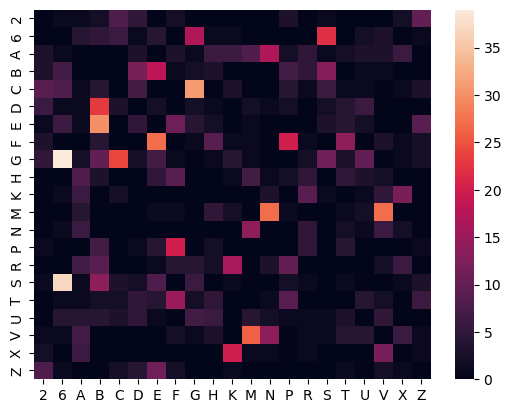

In [15]:
l = np.unique(labels_test)
n_labels = len(l)
mismatches = pd.DataFrame(np.zeros((n_labels, n_labels)), index=l, columns=l, dtype=int)
for i in range(results3.shape[0]):
    for j in range(6):
        if results3[i,j] == labels_test[i,j]:
            continue
        mismatches.loc[labels_test[i,j], results3[i,j]] += 1

sns.heatmap(mismatches)

In [17]:
# Train all models
def train_model(X_train, X_test, y_train, y_test):
    # Clear the current model
    keras.backend.clear_session()
    
    # Store test results
    results = np.zeros((y_test[0].shape[0], 6), dtype=object)
    
    # Hyperparameters
    filters = 32
    shape = 5
    stride = 2
    pad ='same'
    act = 'relu'    
    n_classes = y_train[0].shape[1]
    
    # Layers to be frozen
    feature_layers = [
        Conv2D(filters, shape, strides=stride, padding=pad, activation=act,
               input_shape=X_train.shape[1:]),
        Conv2D(filters, shape, strides=stride, padding=pad, activation=act),
        Conv2D(filters, shape, strides=stride, padding=pad, activation=act),
        MaxPooling2D(pool_size=2),
        Dropout(0.25),
        Flatten()
    ]
    
    # Classification layers
    class_layers = [
        Dense(512, activation=act),
        Dropout(0.25),
        Dense(256, activation=act),
        Dense(n_classes, activation='softmax')
    ]

    # Simple CNN
    model = Sequential(feature_layers + class_layers)
    model.summary()
    
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    print("Character 1")
    model.fit(X_train, y_train[0],
                  batch_size=64,
                  epochs=15,
                  validation_data=(X_test, y_test[0]),
                  shuffle=True)
    
    # Save the prediction results
    y_pred = pred_classes(model.predict(X_test))
    results[:,0] = encoder.inverse_transform(y_pred).flatten()
    print()
    
    # Freeze the feature layers
    for l in feature_layers:
        l.trainable = False
        
    # Train the rest of the models using the frozen layers
    for i in range(1,6):
        print(f"Character {i+1}")
        model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
        model.fit(X_train, y_train[i],
                  batch_size=64,
                  epochs=10,
                  validation_data=(X_test, y_test[i]),
                  shuffle=True)
        
        # Fine tuning
        for l in feature_layers:
            l.trainable = True
        learn_rate = 1e-5
        model.compile(loss='categorical_crossentropy', 
                      optimizer=keras.optimizers.Adam(learn_rate),
                      metrics=['accuracy'])
        model.fit(X_train, y_train[i],
                  batch_size=64,
                  epochs=5,
                  validation_data=(X_test, y_test[i]),
                  shuffle=True)
        
        for l in feature_layers:
            l.trainable = False
        
        y_pred = pred_classes(model.predict(X_test))
        results[:,i] = encoder.inverse_transform(y_pred).flatten()
        print()

    return results

results_4 = train_model(X_train, X_test, y_train, y_test)
label_accuracy(labels_test, results_4)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 25, 125, 32)       832       
                                                                 
 conv2d_1 (Conv2D)           (None, 13, 63, 32)        25632     
                                                                 
 conv2d_2 (Conv2D)           (None, 7, 32, 32)         25632     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 3, 16, 32)        0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 3, 16, 32)         0         
                                                                 
 flatten (Flatten)           (None, 1536)              0         
                                                        

133/133 [==============================] - 16s 118ms/step - loss: 0.3176 - accuracy: 0.8960 - val_loss: 0.6242 - val_accuracy: 0.8073
Epoch 5/5
47/47 [==============================] - 1s 12ms/step

Character 4
Epoch 1/10
133/133 [==============================] - 5s 37ms/step - loss: 3.8772 - accuracy: 0.0748 - val_loss: 2.8592 - val_accuracy: 0.1420
Epoch 2/10
133/133 [==============================] - 4s 27ms/step - loss: 2.5349 - accuracy: 0.2072 - val_loss: 2.0251 - val_accuracy: 0.3753
Epoch 3/10
133/133 [==============================] - 4s 31ms/step - loss: 1.8643 - accuracy: 0.4047 - val_loss: 1.4719 - val_accuracy: 0.5427
Epoch 4/10
133/133 [==============================] - 4s 34ms/step - loss: 1.4180 - accuracy: 0.5423 - val_loss: 1.1797 - val_accuracy: 0.6387
Epoch 5/10
133/133 [==============================] - 4s 28ms/step - loss: 1.1371 - accuracy: 0.6346 - val_loss: 0.9888 - val_accuracy: 0.6927
Epoch 6/10
133/133 [==============================] - 4s 31ms/step - loss:

<Axes: >

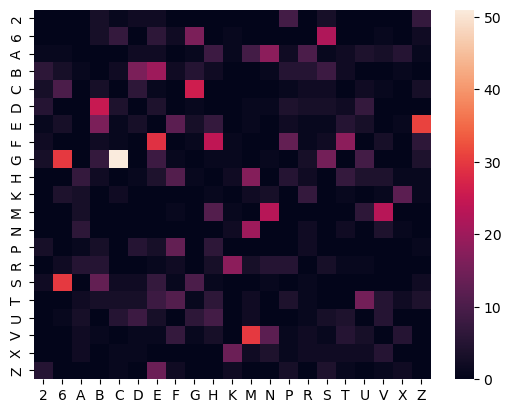

In [19]:
l = np.unique(labels_test)
n_labels = len(l)
mismatches = pd.DataFrame(np.zeros((n_labels, n_labels)), index=l, columns=l, dtype=int)
for i in range(results_4.shape[0]):
    for j in range(6):
        if results_4[i,j] == labels_test[i,j]:
            continue
        mismatches.loc[labels_test[i,j], results_4[i,j]] += 1

sns.heatmap(mismatches)

In [14]:
# Train all models
def train_model(X_train, X_test, y_train, y_test):
    # Clear the current model
    keras.backend.clear_session()
    
    # Store test results
    results = np.zeros((y_test[0].shape[0], 6), dtype=object)
    
    # Hyperparameters
    filters = 32
    shape = 5
    stride = 2
    pad ='same'
    act = 'relu'    
    n_classes = y_train[0].shape[1]
    
    # Layers to be frozen
    feature_layers = [
        Conv2D(filters, shape, strides=stride, padding=pad, activation=act,
               input_shape=X_train.shape[1:]),
        Conv2D(filters, shape, strides=stride, padding=pad, activation=act),
        Conv2D(filters, shape, strides=stride, padding=pad, activation=act),
        MaxPooling2D(pool_size=2),
        Dropout(0.25),
        Flatten()
    ]
    
    # Classification layers
    class_layers = [
        Dense(512, activation=act),
        Dropout(0.25),
        Dense(256, activation=act),
        Dropout(0.25),
        Dense(128, activation=act),
        Dropout(0.25),
        Dense(n_classes, activation='softmax')
    ]

    # Simple CNN
    model = Sequential(feature_layers + class_layers)
    model.summary()
    
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    print("Character 1")
    model.fit(X_train, y_train[0],
                  batch_size=64,
                  epochs=15,
                  validation_data=(X_test, y_test[0]),
                  shuffle=True)
    
    # Save the prediction results
    y_pred = pred_classes(model.predict(X_test))
    results[:,0] = encoder.inverse_transform(y_pred).flatten()
    print()
    
    # Freeze the feature layers
    for l in feature_layers:
        l.trainable = False
        
    # Train the rest of the models using the frozen layers
    for i in range(1,6):
        print(f"Character {i+1}")
        model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
        model.fit(X_train, y_train[i],
                  batch_size=64,
                  epochs=10,
                  validation_data=(X_test, y_test[i]),
                  shuffle=True)
        
        # Fine tuning
        for l in feature_layers:
            l.trainable = True
        learn_rate = 1e-5
        model.compile(loss='categorical_crossentropy', 
                      optimizer=keras.optimizers.Adam(learn_rate),
                      metrics=['accuracy'])
        model.fit(X_train, y_train[i],
                  batch_size=64,
                  epochs=5,
                  validation_data=(X_test, y_test[i]),
                  shuffle=True)
        
        for l in feature_layers:
            l.trainable = False
        
        y_pred = pred_classes(model.predict(X_test))
        results[:,i] = encoder.inverse_transform(y_pred).flatten()
        print()

    return results

results5 = train_model(X_train, X_test, y_train, y_test)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 25, 125, 32)       832       
                                                                 
 conv2d_1 (Conv2D)           (None, 13, 63, 32)        25632     
                                                                 
 conv2d_2 (Conv2D)           (None, 7, 32, 32)         25632     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 3, 16, 32)        0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 3, 16, 32)         0         
                                                                 
 flatten (Flatten)           (None, 1536)              0         
                                                        

133/133 [==============================] - 19s 136ms/step - loss: 0.4866 - accuracy: 0.8399 - val_loss: 0.6037 - val_accuracy: 0.8053
Epoch 2/5
133/133 [==============================] - 18s 133ms/step - loss: 0.4897 - accuracy: 0.8367 - val_loss: 0.5920 - val_accuracy: 0.8067
Epoch 3/5
133/133 [==============================] - 18s 136ms/step - loss: 0.4829 - accuracy: 0.8388 - val_loss: 0.5850 - val_accuracy: 0.8093
Epoch 4/5
133/133 [==============================] - 17s 132ms/step - loss: 0.4522 - accuracy: 0.8481 - val_loss: 0.5764 - val_accuracy: 0.8167
Epoch 5/5
47/47 [==============================] - 1s 11ms/step

Character 4
Epoch 1/10
133/133 [==============================] - 6s 40ms/step - loss: 3.7303 - accuracy: 0.0585 - val_loss: 2.9992 - val_accuracy: 0.0920
Epoch 2/10
133/133 [==============================] - 4s 31ms/step - loss: 2.8189 - accuracy: 0.1181 - val_loss: 2.4930 - val_accuracy: 0.2207
Epoch 3/10
133/133 [==============================] - 4s 34ms/step - lo

In [15]:
label_accuracy(labels_test, results5)

Per Character Accuracy: 83.53%
Per Label Accuracy: 41.93%


<Axes: >

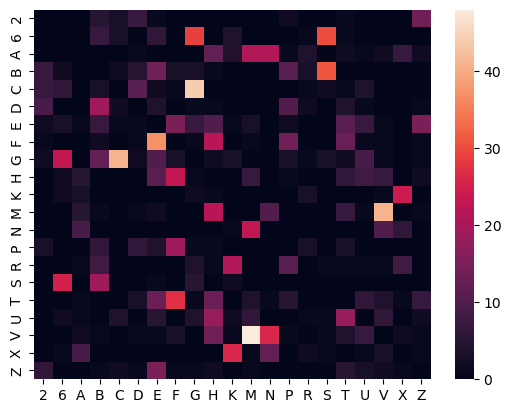

In [16]:
l = np.unique(labels_test)
n_labels = len(l)
mismatches = pd.DataFrame(np.zeros((n_labels, n_labels)), index=l, columns=l, dtype=int)
for i in range(results5.shape[0]):
    for j in range(6):
        if results5[i,j] == labels_test[i,j]:
            continue
        mismatches.loc[labels_test[i,j], results5[i,j]] += 1

sns.heatmap(mismatches)